In this paper I will be implementing this paper https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2244633. The paper advocates for using an absolute momentum strategy. 

In [10]:
from backtester import *


The original paper used MSCI USA index to act as a proxy for midcap assets. I will be using the IShares Morningstar Mid-Cap Value ETF as a stand in for the performance of mid-cap equities. I would prefer to use QUAL however there is less than 10 years worth of data available.

In [11]:
#Name of the security we are interested in

secname = 'IMCV'

# How long to make the momentum formation period, the original paper found the best period to be 12 months. 

formation = 12

# Guaranteed rate of return, this will be used as the benchmark for working out the Sharpe Ratio.

Guaranteed_rate_of_return = 0.01

# Transaction costs, as a percentage of the total transaction size that are charged every time 

transaction_costs = 0.00

In [12]:
close_data = getdata(secname, '10y', 'Close', "1mo")

In [13]:
data = pd.DataFrame(close_data).copy().dropna()
display(data)


,Close
Date,
2012-12-01,21.775295
2013-01-01,23.667431
2013-02-01,23.973810
2013-03-01,25.185949
2013-04-01,25.699451
...,...
2022-08-01,61.823444
2022-09-01,55.538837
2022-10-01,61.639999


Rather than selling and holding cash, in the paper the strategy will have us buy treasury bonds, in this case I have used is the 13 week treasury bond, as the paper did.

In [14]:
tresurybond = getdata('^IRX', '10y', 'Close', "1mo")

In [15]:
treasurydata = pd.DataFrame(tresurybond).copy().dropna().rename(columns={'Close':'TByeild'})
display(treasurydata)


,TByeild
Date,
2012-12-01,0.035
2013-01-01,0.065
2013-02-01,0.100
2013-03-01,0.065
2013-04-01,0.045
...,...
2022-08-01,2.860
2022-09-01,3.180
2022-10-01,3.975


The original paper has positions revaluated monthly which I have also done.

In [16]:
# Creating the buy and sell signals based on the momentum of the previous 12 months. 

def momentum(data_levels,tbonds, formation_period = 12, tolerance = 0.00):
    
    #Combine the two dataframes so we arent going between multiple dataframes
    
    data = pd.merge(data_levels,tbonds,left_index=True, right_index=True, how='outer')
    
    # The first thing that we need to do is work out the formation periods for the strategy, the default is 12 months.
    # It takes the percentage increase in the price of the asset and takes away the yield on the 13 week bill. If this number is positive then the asset is outperforming the bill, if it is negative then the asset is not.
    
    data['Signals']  = (((data['Close']-data['Close'].shift(periods= formation))/data['Close'].shift(periods= 12))-data['TByeild']).dropna()

    data['Signals'] = data['Signals'].apply(lambda x: +1 if x>=0 else -1)
    
    # Traditionally we would also look at the month ahead and decide if we should buy or sell, however given that we are backtesting, we would be implementing look ahead bias. 
    # If the price we due to decrease we would sell thus ensuring that positive returns are always made. Therefore I will only use the previous 12 months as indicative of momentum. 
    #This is analogous to the papers methodology. 
    return data

The usual backtester that I have used will not be applicable here, given that the paper suggests that instead of holding cash when not taking a positions, it will take a 13 week treasury bill. 

In [17]:
def backtestert(signals,price,tbill ,  tcost = 0.001,):

#Make a quick numpy array to save the money that will be made for possible value that the stock could be sold at and the cash on hand, start with one dollar so its not empty.

        pos_val = np.zeros(np.shape(price))
        cash    = np.zeros(np.shape(price))
        cash[0] = 1
        
        #loop through each day as though we are going through and actually implementing the strategy as we go

        for i,val in enumerate(price):
            
            #if we are on the last day exit the loop we are done.

            if i == len(price)-1:
                break
            
            # The number we are given for the 3 month bill is the annualized yield, however we might only want to hold this bill for a month, so we need to work out the monthly returns on the bill.

            if signals[i] == -1:

                cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]*(1+(tbill[i]/12)/100)
                pos_val[i+1] = 0
                
            #If the signal that day is to buy, what we will do is take all of the cash that we have, divide it by the cost of the security to work out how many we can buy
            #factoring in the cost of the brockerage, we then add it to any stock we held from the pervious day

            elif signals[i] == 1:

                pos_val[i+1] = (cash[i] / val)*((1-tcost)) + pos_val[i]
                cash[i+1] = 0

        #then our returns are the amount of cash left each day plus the the price times the amount of the security that we have

        returns = [a*b for a,b in zip(pos_val,price)] + cash
        
        #lastly we turn this into a data frame too
        
        return pd.DataFrame(returns, index = price.index)

Now to run the tests to see if how they perform

Winrate of ABS Momentum 0.6129032258064516
Final return of ABS Momentum 1.4318493926475737
Sharpe ratio of ABS Momentum 2.6065202571594446
Maximum Drawdown of ABS Momentum -0.0453891611049301


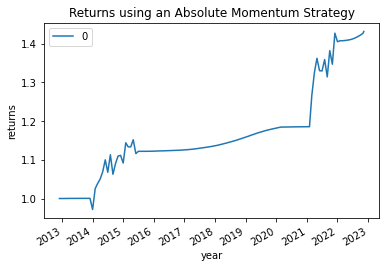

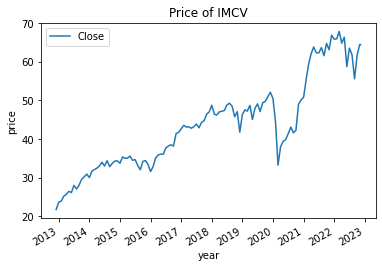

In [18]:
signals = momentum(data, treasurydata, formation_period= formation ,tolerance= 0 )

returns = backtestert(signals['Signals'],signals['Close'],signals['TByeild'],tcost= transaction_costs)
returns.plot(xlabel = 'year',ylabel='returns',title= "Returns using an Absolute Momentum Strategy")
data.plot(xlabel='year',ylabel='price',title='Price of {}'.format(secname))

returns.tail(5)

print('Winrate of ABS Momentum '+ str(winrate(signals,returns)))
print('Final return of ABS Momentum '+ str(returns.iloc[-1][0]))
print('Sharpe ratio of ABS Momentum '+ str(Sharperatio(returns,tradingdays=12,rrr=Guaranteed_rate_of_return )[0]))
print('Maximum Drawdown of ABS Momentum '+ str(MDD(returns[0])))


Having backtested the strategy proposed by the authors I have found an abysmal sharpe ratio, and a win rather that is mildly better than that of flipping a coin. Therefore as it stands this strategy does not line up with the results of the original paper, which only included data up till 2014. I would note that the sharpe ration is only calculated over the last year and not over all of the data.